In [50]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.strip_map_SAR_processor import StripMapSARProcessor
from mmwave_radar_processing.processors.synthetic_array_beamformer_processor import SyntheticArrayBeamformerProcessor
from mmwave_radar_processing.plotting.plotter_synthetic_array_data import PlotterSyntheticArrayData
from mmwave_radar_processing.plotting.movies_synthetic_array_data import MovieGeneratorSyntheticArrayData
from mmwave_radar_processing.detectors.CFAR import CaCFAR_1D,CaCFAR_2D

In [51]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadSAR_2_sr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [52]:
#load the dataset
# dataset_name = "RadSAR_2_CPSL"
dataset_name = "RadSAR_2_WILK"
dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

found 1040 radar samples
found 1040 lidar samples
found 1040 camera samples
found 1040 imu (orientation only) samples
found 1040imu (full data) samples
found 1040 vehicle velocity samples


In [53]:
cfar_2d = CaCFAR_2D(
    num_guard_cells=np.array([2,5]),
    num_training_cells=np.array([3,15]),
    false_alarm_rate=0.001,
    resp_border_cells=np.array([5,5]),
    mode="full"
)

processor_sabf = SyntheticArrayBeamformerProcessor(
    config_manager=cfg_manager,
    cfar=cfar_2d,
    az_angle_bins_rad=\
                np.deg2rad(np.linspace(
                    start=-35,stop=35,num=80
                 )),
    el_angle_bins_rad=\
                np.deg2rad(np.linspace(
                    start=-60,
                    stop=60,
                    num=16
                ))
)

processor_stripMapSAR = StripMapSARProcessor(
    config_manager=cfg_manager,
    az_angle_range_rad=np.deg2rad(np.array([-50,50]))
)

synthetic_array_plotter = PlotterSyntheticArrayData(
    config_manager=cfg_manager,
    processor_SABF=processor_sabf,
    processor_stripMapSAR=processor_stripMapSAR,
    min_vel=0.4
)

movie_generator = MovieGeneratorSyntheticArrayData(
    cpsl_dataset=dataset,
    plotter=synthetic_array_plotter,
    processor=processor_sabf,
    temp_dir_path="~/Downloads/syntheticArrays"
)

alpha: 6.968355977686613 (mag), 16.86260656902793 dB
found temp dir: /home/david/Downloads/syntheticArrays
clearing temp directory /home/david/Downloads/syntheticArrays


In [60]:
idx = 100
while np.abs(np.mean(dataset.get_vehicle_vel_data(idx)[:,1])) < 0.4:
    idx += 1
vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])

processor_sabf._generate_array_geometries(
    vels=np.array([-vel,0,0])
)
print(vel)

0.4792806135141291


In [61]:
#get the velocity of the vehicle
vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])

#generate the array geometry
processor_sabf._generate_array_geometries(
    vels=np.array([-vel,0,0])
)
#get the adc cube
adc_cube = dataset.get_radar_data(idx)
#compute the response
resp = processor_sabf.process(adc_cube)
dets = processor_sabf.beamformed_dets
#get the lidar pointcloud for gt comparison
lidar_pc_raw = dataset.get_lidar_point_cloud_raw(idx)

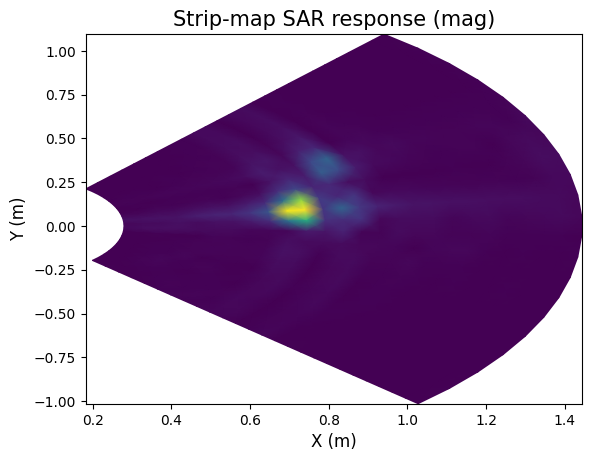

5.60478770061934e-05


In [71]:
#SAR Processing
sar_resp = processor_stripMapSAR.process(
    adc_cube=adc_cube,
    vel_m_per_s=vel,
    sensor_height_m=0.24,
    rx_index=7,
    max_SAR_distance=1.5
)

synthetic_array_plotter.plot_stripmap_SAR_resp(
    resp=sar_resp,
    convert_to_dB=False,
    show=True
)

sar_bins = processor_stripMapSAR.ground_range_bins
close = sar_bins[1] - sar_bins[0]
far = sar_bins[-1] - sar_bins[-2]
diff = (close - far) * 1e3
print(diff)

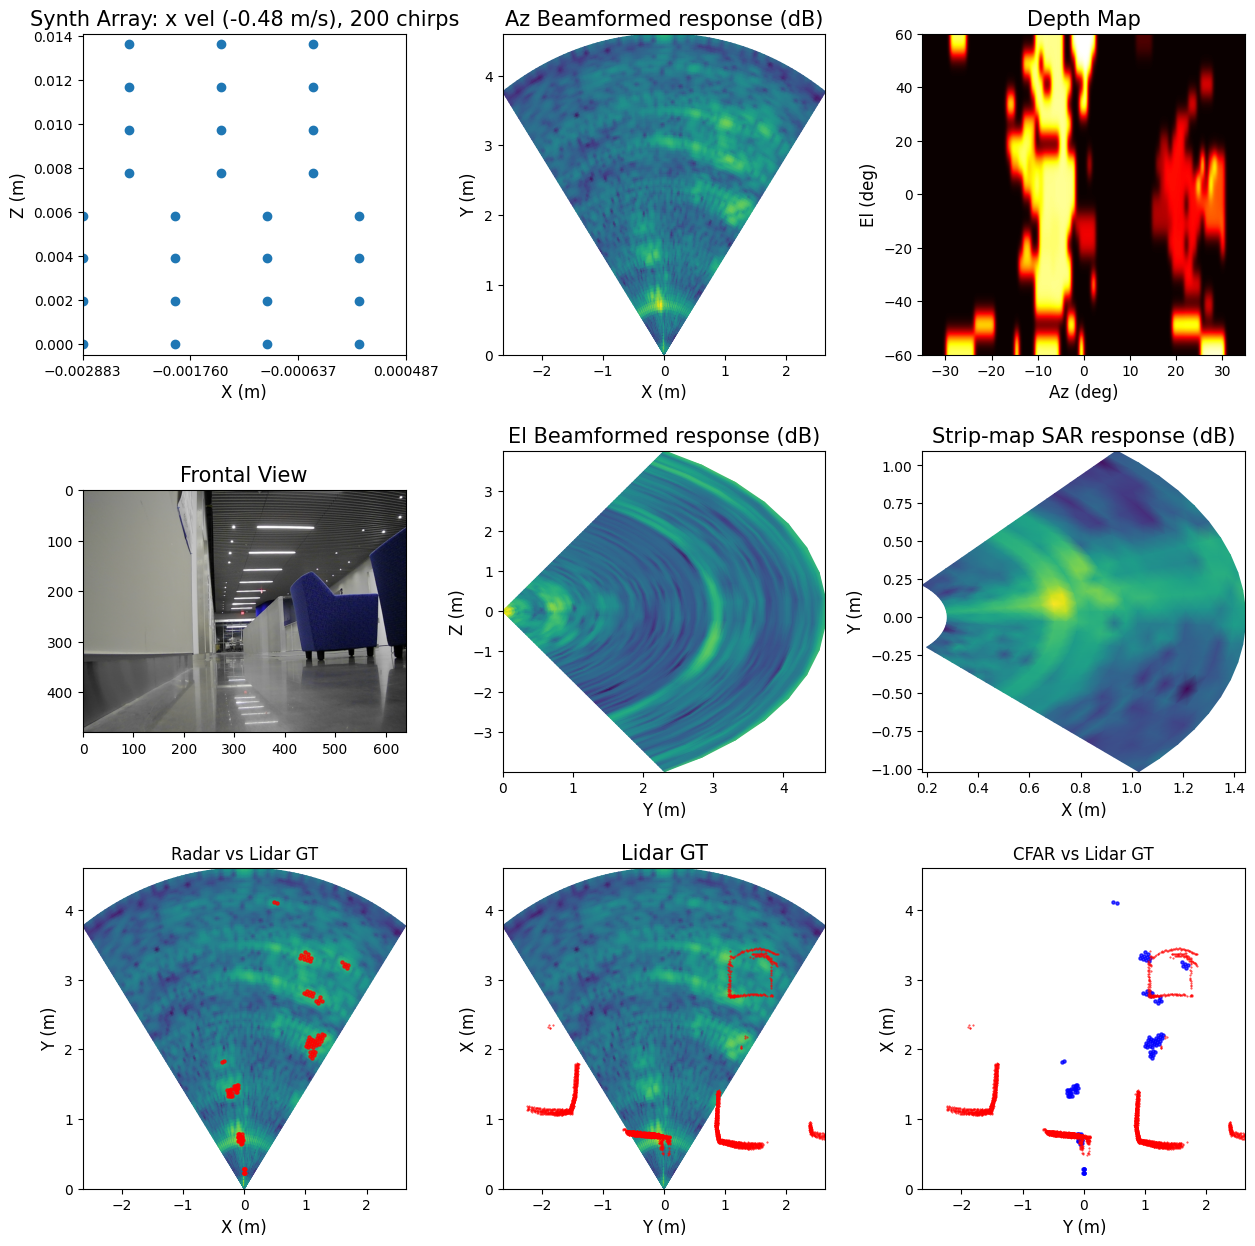

In [64]:
synthetic_array_plotter.plot_compilation(
    adc_cube=adc_cube,
    vels=np.array([-vel,0,0]),
    camera_view=dataset.get_camera_frame(idx),
    lidar_pc_raw=lidar_pc_raw,
    lidar_radar_offset_rad=np.deg2rad(180),
    convert_to_dB=True,
    cmap="viridis",
    show=True
)

  1%|          | 1/133 [00:00<00:46,  2.86it/s]

100%|██████████| 133/133 [00:14<00:00,  9.40it/s]


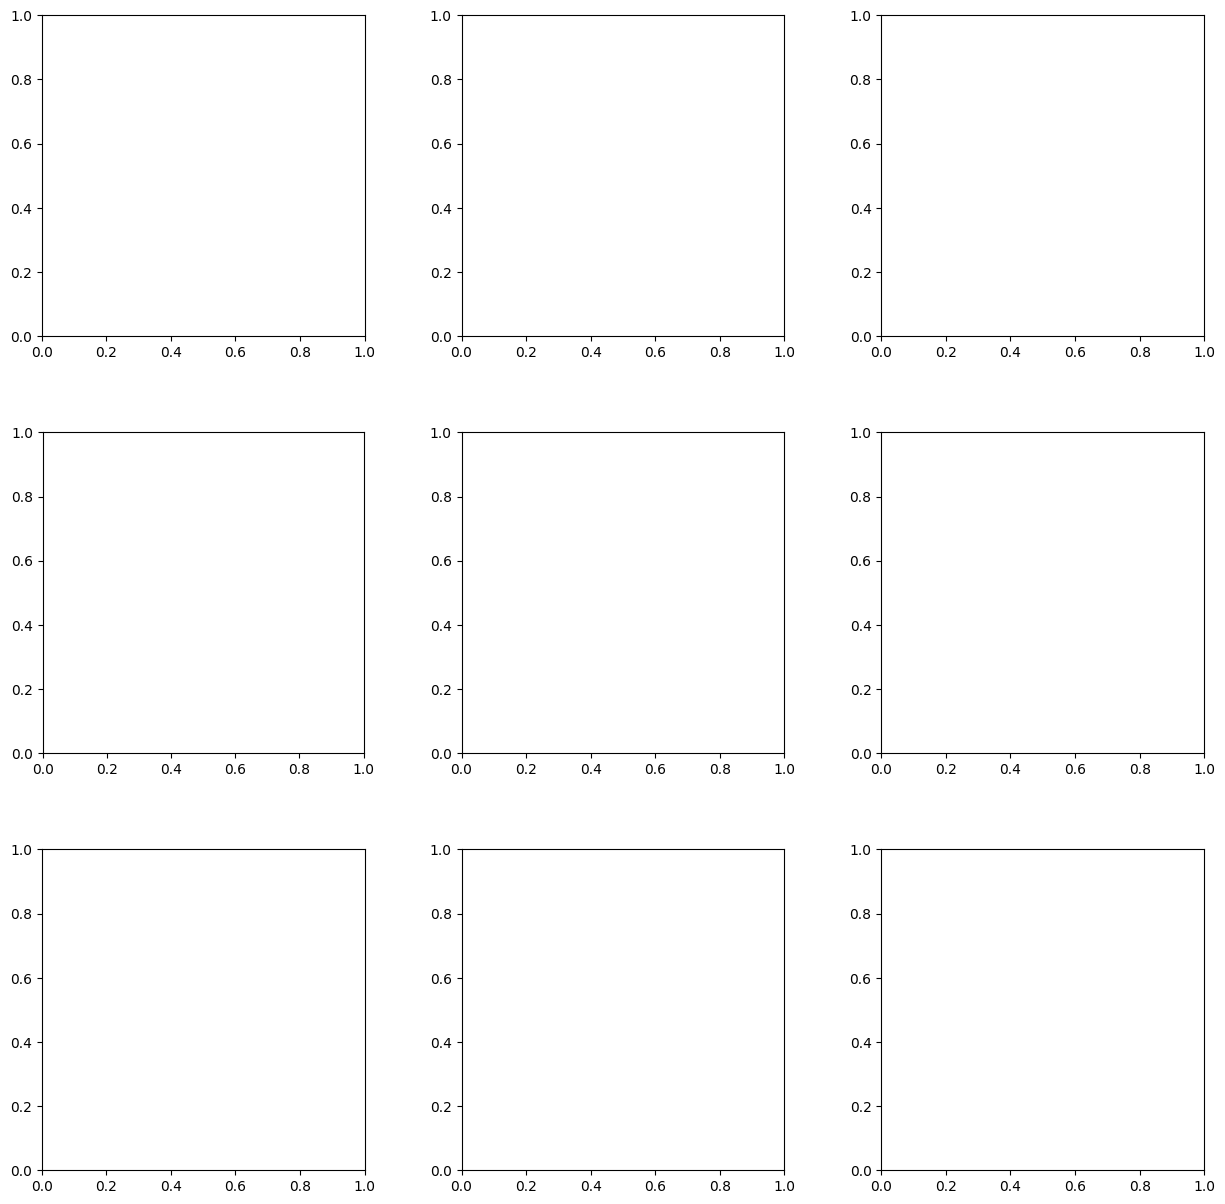

In [20]:
#generate the movie
movie_generator.initialize_figure(nrows=3,ncols=3,figsize=(15,15))

movie_generator.generate_movie_frames(
    cmap="viridis",
    convert_to_dB=False,
    lidar_radar_offset_rad=np.deg2rad(180)
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_mag_SAR.mp4".format(dataset_name),fps=fps)

alpha: 7.54008909748074 (mag), 17.54752955483744 dB


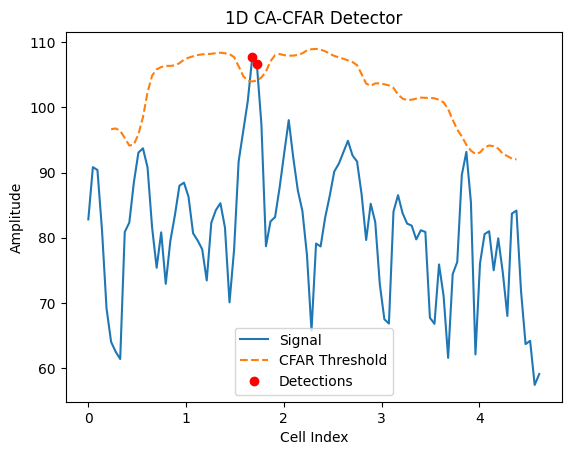

In [21]:
cfar = CaCFAR_1D(
    config_manager=cfg_manager,
    num_guard_cells=3,
    num_training_cells=20,
    false_alarm_rate=1e-3,
    resp_border_cells=5,
    mode="full"
)

cfar.plot_cfar(
    signal=resp[:,55,10],
    show=True
)